Терёхина Ирина Юрьевна

Задача: 

Методом бутстрепинга проверить гипотезу H0 о том, что CTR  на двух сплитах можнообъяснить шумами. Выполнить данный подсчет для любой другой кликовой метрики, например: количество отказов (доля сессий без кликов), доля кликов в первый результат, позиция последнего клика, среднее количество кликов на сессию и т.д.

In [29]:
import pandas as pd
import numpy as np
import random
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
split1 = pd.read_csv('home_work_data/c1.txt', header=None)
split2 = pd.read_csv('home_work_data/c2.txt', header=None)

In [31]:
N = len(split1)
split1.head()

,0
0,1 1 1 0 0 0 0 0 0 0
1,0 0 0 0 0 0 0 0 0 0
2,1 0 0 0 0 0 0 0 0 0
3,1 1 1 0 0 0 0 0 0 0
4,1 0 0 0 0 0 0 0 0 0


In [32]:
def check_any_click(session):
    values = [int(i) for i in list(session)[0].split()]
    if np.sum(values) == 0:
        return 0
    else:
        return 1
    
def check_first_click(session):
    return int(list(session)[0].split()[0])

In [33]:
split1['was_clicks'] = split1.apply(check_any_click, axis=1)
split1['was_clicks@1'] = split1.apply(check_first_click, axis=1)
split1.head()

,0,was_clicks,was_clicks@1
0,1 1 1 0 0 0 0 0 0 0,1,1
1,0 0 0 0 0 0 0 0 0 0,0,0
2,1 0 0 0 0 0 0 0 0 0,1,1
3,1 1 1 0 0 0 0 0 0 0,1,1
4,1 0 0 0 0 0 0 0 0 0,1,1


In [34]:
split2['was_clicks'] = split2.apply(check_any_click, axis=1)
split2['was_clicks@1'] = split2.apply(check_first_click, axis=1)
split2.head()

,0,was_clicks,was_clicks@1
0,0 0 0 0 0 0 0 0 0 0,0,0
1,1 0 0 0 0 0 0 0 0 0,1,1
2,0 0 0 0 0 0 0 0 0 0,0,0
3,1 0 0 1 0 0 0 0 0 0,1,1
4,0 0 0 0 0 0 0 0 0 0,0,0


Значения для метрик CTR, Abandonment Rate, Click@1. Количество сессий в одной группе -- 100.

In [35]:
batch_size = 100

ctr_split1 = []
ctr_split2 = []
ar_split1 = [] # abandonment rate
ar_split2 = []
cf_split1 = [] # click at first doc
cf_split2 = []

for batch_num in range(int(N / batch_size)):
    ctr1 = sum(split1.loc[batch_num:batch_num+batch_size-1, 'was_clicks']) / batch_size
    ctr2 = sum(split2.loc[batch_num:batch_num+batch_size-1, 'was_clicks']) / batch_size

    ctr_split1.append(ctr1)
    ctr_split2.append(ctr2)
    
    ar_split1.append(1 - ctr1)
    ar_split2.append(1 - ctr2)
    
    cf1 = sum(split1.loc[batch_num:batch_num+batch_size-1, 'was_clicks@1']) / batch_size
    cf2 = sum(split2.loc[batch_num:batch_num+batch_size-1, 'was_clicks@1']) / batch_size
    cf_split1.append(cf1)
    cf_split2.append(cf2)

In [36]:
len(ctr_split1), N

(10000, 1000000)

In [37]:
ctr_split1[:5], ar_split1[:5], cf_split1[:5]

([0.75, 0.75, 0.76, 0.76, 0.76],
 [0.25, 0.25, 0.24, 0.24, 0.24],
 [0.5, 0.49, 0.5, 0.5, 0.5])

In [38]:
ctr_split2[:5], ar_split2[:5], cf_split2[:5]

([0.72, 0.73, 0.73, 0.74, 0.74],
 [0.28, 0.27, 0.27, 0.26, 0.26],
 [0.31, 0.32, 0.31, 0.31, 0.3])

Bootstraping

H_0 -- выборки взяты из одного распределения, отклонения вызваны случайными флуктуациями

In [40]:
batch_size = 1000
num_of_experiments = 100
sample_size = len(ctr_split1)

In [41]:
def check_ttest(test_data1, test_data2, t_star=1.96, alpha=0.05):
    stat, pvalue = stats.ttest_ind(test_data1, test_data2)
    print("stat, pvalue for batch:", stat, pvalue)
    if pvalue < alpha: # possible to reject H0
        if stat > t_star:
            return 1
    return 0

CTR:

Как выглядит распределение для сплитов:

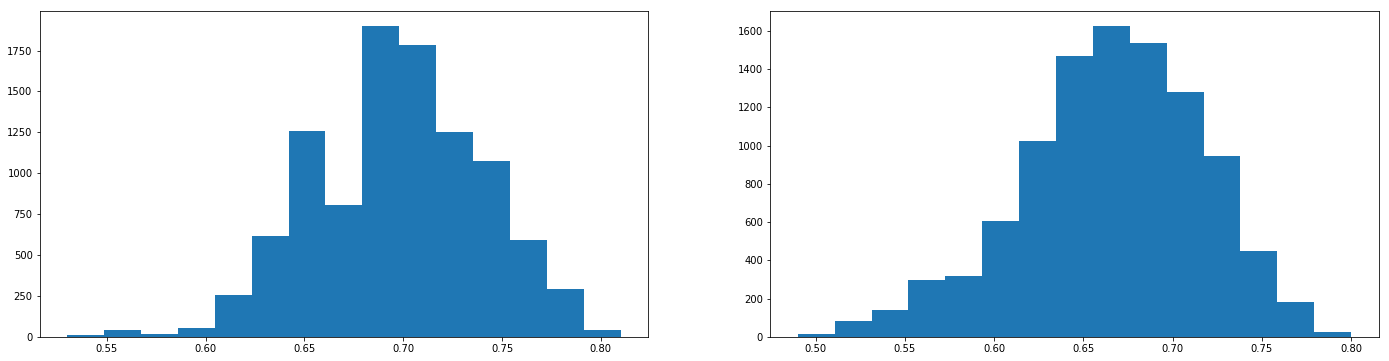

In [20]:
fig = plt.figure(figsize=(24, 6))

ax1 = plt.subplot(121)
plt.hist(ctr_split1, 15)

ax2 = plt.subplot(122)
plt.hist(ctr_split2, 15)

plt.show()

In [21]:
ctr_count = 0

ctr_split1 = np.array(ctr_split1)
ctr_split2 = np.array(ctr_split2)

for _ in range(num_of_experiments):
    idx = random.sample(list(range(sample_size)), batch_size)

    test_data1 = ctr_split1[idx]
    test_data2 = ctr_split2[idx]
    ctr_count += check_ttest(test_data1, test_data2)
        
ctr_acl = ctr_count / num_of_experiments
print()

print("Размер выборки:", sample_size)
print("Количество экспериментов:", num_of_experiments)
print("Размер выборки в эксперименте:", batch_size)
print("Доля случаев, когда H0 была отвергнута:", ctr_acl)

stat, pvalue for batch: 15.87890283028367 1.454828809822094e-53
stat, pvalue for batch: 16.12528149773871 4.3573292790828194e-55
stat, pvalue for batch: 16.089814580034673 7.23852680796795e-55
stat, pvalue for batch: 13.795261437925337 2.0228565781506046e-41
stat, pvalue for batch: 13.962953124049356 2.3951606700873287e-42
stat, pvalue for batch: 17.32133530828962 9.841330600507897e-63
stat, pvalue for batch: 15.210552274626735 1.6009084862390686e-49
stat, pvalue for batch: 14.911507396361735 9.302979399072894e-48
stat, pvalue for batch: 16.111419226772288 5.313976034052589e-55
stat, pvalue for batch: 16.97636774988202 1.7383898990520464e-60
stat, pvalue for batch: 14.712662336823826 1.337792357282122e-46
stat, pvalue for batch: 15.420399412088713 8.911704132821625e-51
stat, pvalue for batch: 14.554724836249365 1.0893207648992932e-45
stat, pvalue for batch: 15.89143591857167 1.2182657547122826e-53
stat, pvalue for batch: 14.533415050428557 1.44357895332653e-45
stat, pvalue for batch: 1

AR

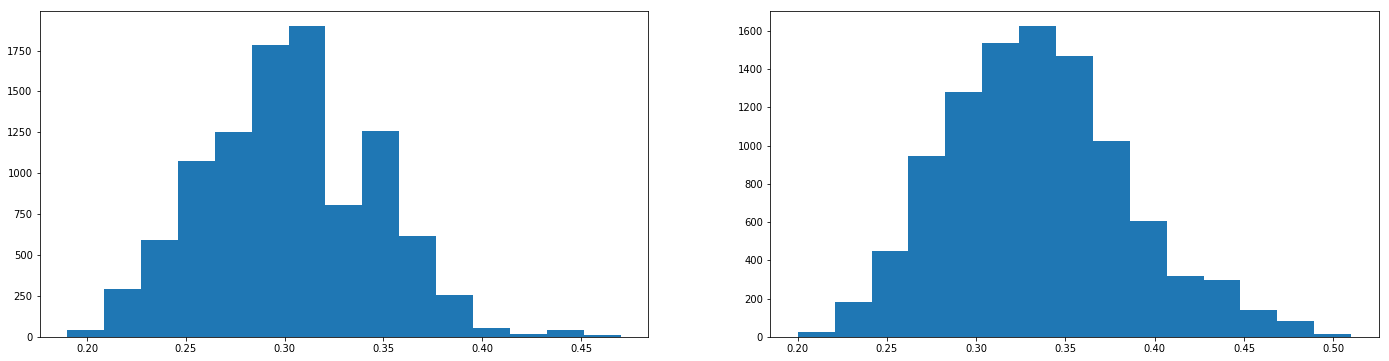

In [22]:
fig = plt.figure(figsize=(24, 6))

ax1 = plt.subplot(121)
plt.hist(ar_split1, 15)

ax2 = plt.subplot(122)
plt.hist(ar_split2, 15)

plt.show()

In [23]:
count = 0

ar_split1 = np.array(ar_split1)
ar_split2 = np.array(ar_split2)

for _ in range(num_of_experiments):
    idx = random.sample(list(range(sample_size)), batch_size)

    test_data1 = ar_split1[idx]
    test_data2 = ar_split2[idx]
    count += check_ttest(test_data1, test_data2)
        
acl = count / num_of_experiments
print()

print("Размер выборки:", sample_size)
print("Количество экспериментов:", num_of_experiments)
print("Размер выборки в эксперименте:", batch_size)
print("Доля случаев, когда H0 была отвергнута:", acl)

stat, pvalue for batch: -16.377773878943465 1.1463249366321468e-56
stat, pvalue for batch: -14.834992564537757 2.6036648453295235e-47
stat, pvalue for batch: -14.867887971730253 1.6735896694440226e-47
stat, pvalue for batch: -14.999941457345955 2.81688136778464e-48
stat, pvalue for batch: -16.165268822180494 2.456135824201062e-55
stat, pvalue for batch: -15.223792831484168 1.3354137400215438e-49
stat, pvalue for batch: -16.77476411717823 3.450365490447292e-59
stat, pvalue for batch: -14.805417838589781 3.8713116132161927e-47
stat, pvalue for batch: -16.236672277350284 8.800669047522706e-56
stat, pvalue for batch: -14.363384705821376 1.348978843787977e-44
stat, pvalue for batch: -15.12103430911424 5.437260445900058e-49
stat, pvalue for batch: -15.813499460336692 3.66639314211492e-53
stat, pvalue for batch: -14.78797946657643 4.890001376578571e-47
stat, pvalue for batch: -16.357833697950188 1.5302250401395862e-56
stat, pvalue for batch: -15.680206161082676 2.3900182319848763e-52
stat, pv

Доля кликов на первый документ (click@1)

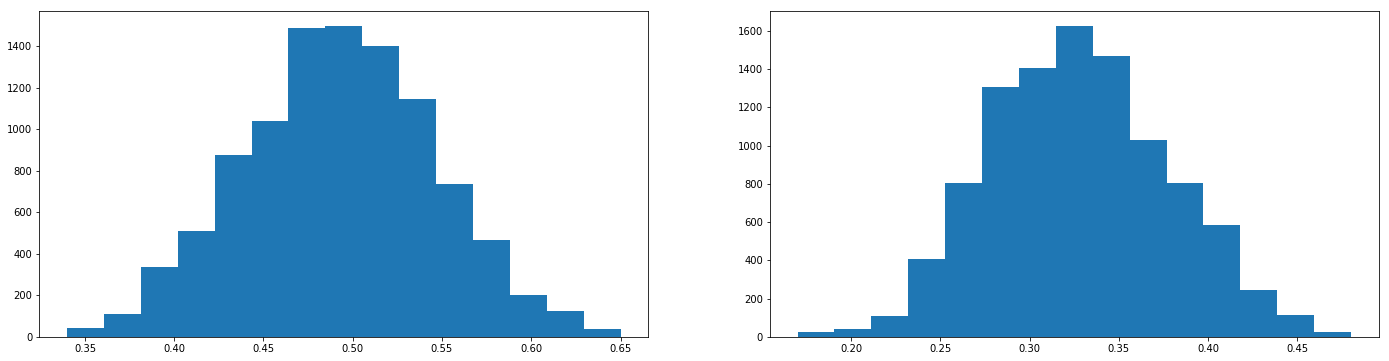

In [42]:
fig = plt.figure(figsize=(24, 6))

ax1 = plt.subplot(121)
plt.hist(cf_split1, 15)

ax2 = plt.subplot(122)
plt.hist(cf_split2, 15)

plt.show()

In [43]:
count = 0

cf_split1 = np.array(cf_split1)
cf_split2 = np.array(cf_split2)

for _ in range(num_of_experiments):
    idx = random.sample(list(range(sample_size)), batch_size)

    test_data1 = cf_split1[idx]
    test_data2 = cf_split2[idx]
    count += check_ttest(test_data1, test_data2)
        
acl = count / num_of_experiments
print()

print("Размер выборки:", sample_size)
print("Количество экспериментов:", num_of_experiments)
print("Размер выборки в эксперименте:", batch_size)
print("Доля случаев, когда H0 была отвергнута:", acl)

stat, pvalue for batch: 73.16640296143132 0.0
stat, pvalue for batch: 73.23271696866088 0.0
stat, pvalue for batch: 76.78037981672041 0.0
stat, pvalue for batch: 71.8925959292488 0.0
stat, pvalue for batch: 72.53185654075553 0.0
stat, pvalue for batch: 71.68673790133681 0.0
stat, pvalue for batch: 73.17851719884166 0.0
stat, pvalue for batch: 74.64244870182887 0.0
stat, pvalue for batch: 74.99429466798756 0.0
stat, pvalue for batch: 73.24795057207766 0.0
stat, pvalue for batch: 74.25310910398262 0.0
stat, pvalue for batch: 73.97223657777099 0.0
stat, pvalue for batch: 73.46505178553593 0.0
stat, pvalue for batch: 72.30662997245047 0.0
stat, pvalue for batch: 72.87923651734468 0.0
stat, pvalue for batch: 74.4862142768792 0.0
stat, pvalue for batch: 76.54747593314006 0.0
stat, pvalue for batch: 72.59069886525423 0.0
stat, pvalue for batch: 75.32845131583782 0.0
stat, pvalue for batch: 73.83936635864211 0.0
stat, pvalue for batch: 70.76622683684047 0.0
stat, pvalue for batch: 72.851320201

Во втором сплите увеличилось среднее по метрике AR, уменьшилось по метрике Click@1, CTR. Все это свидетельствует об ухудшении выдачи, то есть сплит 2 хуже, чем сплит 1.